In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import Adam,Adadelta,RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,ResNet50,ResNet152V2
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,TensorBoard
from tensorflow.keras import regularizers
import numpy as np
import cv2 as cv
import os
import random

## 图片格式转换

数据本身是pgm格式，这个格式本身不影响训练，也不影响读取数据，但是他最大的问题是，在WIN端目录下无法预览，这就有点难受了，因此我们将图片转换为png格式方便我们直接从目录中预览

In [2]:
train_dir= 'data/faces_siamese/Training'
test_dir='data/faces_siamese/Testing'

orig_train='data/faces/Training'
orig_test='data/faces/Testing'


def pgmtopng(originalpath,path):
    if not os.path.exists(path):
        os.mkdir(path)
    for i in os.listdir(originalpath):
        #建立训练集与测试集文件夹
        if not os.path.exists(path+'/'+i):
            os.mkdir(path+'/'+i)
            
        #将每个类里面的图片变为png到指定目录    
        for j in os.listdir(originalpath+'/'+i):
            imgpath=originalpath+'/'+i+'/'+j
            img=cv.imread(imgpath)
            imgname=j.split('.')[0]
            savepath=path+'/'+i+'/'+imgname+'.png'
            cv.imwrite(savepath,img)
            
pgmtopng(orig_train,train_dir)
pgmtopng(orig_test,test_dir)

这个时候，文件夹目录下应该有相同的图片了，也可以进行预览

## 载入数据

载入数据的源代码是基于keras官方Siamese例子，但是个人感觉写的也不好，并没有将所有组合全部遍历，但不影响结果，
我们姑且按这个格式进行修改，最终我们可以使用yield来实现从硬盘分批读取图片，以实现未来内存无法储存大量图片所带来的问题。<br /><br />
为什么不适用ImageDataGenerator 类方法中的flow_from_directory？<br />
keras官方自带功能包含了从硬盘分批读取图片，为什么要我们自己撰写呢.Keras官方自带案例的确可以实现单张从内存里读取，但是这是一个单张的generator无法直接fed到孪生网络模型中，如果将两个生成器拼合成一个，原理上是可行的，但最大问题是官方自带的生成器是随机的，那么随机的拼合最大的问题是产生不均衡的样本，因为非同人脸的图片比例一定是很高的，这对于我们的学习是非常不利的。若将keras的学习器固定为非随机，那么产生的图片又是连续的，数量也十分有限，加之我们数据量本身就不大因此也不适合

In [3]:
train_dir= 'data/faces_siamese/Training'
test_dir='data/faces_siamese/Testing'

def read_image(imageName):
    im = cv.imread(imageName)
    im=cv.resize(im,(64,64))/255.
    data = np.array(im)
    return data.astype('float32')

def loadData(datadir):
    images_path=[]
    labels=[]
    count=0
    for i in os.listdir(datadir):
        count+=1
        for fn in os.listdir(os.path.join(datadir, str(i))):
            if fn.endswith('.png'):
                fd = os.path.join(datadir, str(i), fn)
                images_path.append(fd)
                labels.append(str(i))
    return images_path,np.array(labels),count


def doubleGenerator(x, digit_indices,num_classes,batch_size):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    img1list = []
    img2list = []
    labels = []
    count=0
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    while True:
        for d in range(num_classes):
            for i in range(n):
                z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
                img1,img2=read_image(x[z1]),read_image(x[z2])
                img1list.append(img1)
                img2list.append(img2)
                inc = random.randrange(1, num_classes)
                dn = (d + inc) % num_classes
                z1, z2 = digit_indices[d][i], digit_indices[dn][i]
                img1,img2=read_image(x[z1]),read_image(x[z2])
                img1list.append(img1)
                img2list.append(img2)
                labels += [1., 0.]#每次保持一个正例和一个反例
                count+=1
                if count==batch_size:#满足指定batch size后yield
                    count=0
                    yield [np.array(img1list),np.array(img2list)], np.array(labels)
                    img1list = []
                    img2list = []
                    labels = []

#读取每张图片的路径，label和类别总数
x_train,y_train,train_classes=loadData(train_dir)
x_test,y_test,test_classes=loadData(test_dir)

#获取每张图片label对应的index
digit_indices_train = [np.where(y_train == i)[0] for i in os.listdir(train_dir)]
digit_indices_test = [np.where(y_test == i)[0] for i in os.listdir(test_dir)]

## 构建Siamese网络
采用预训练模型（Resnet）构建，可以极大的加快收敛，能在较少的数据集上取得优秀的结果

In [4]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1.
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


def base_net(input_tensor_shape):
    
    '''Base network to be shared (eq. to feature extraction).
    '''
    input=Input(input_tensor_shape)
    conv_base = ResNet50(weights='imagenet',
                         include_top=False)
    conv_base.trainable=False
    net=conv_base(input)
    net=layers.Flatten()(net)
    #net=layers.Dropout(0.1)(net)
    net=layers.Dense(512, activation='relu')(net)
    return Model(input, net)


def accuracy(y_true, y_pred): # Tensor上的操作
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

def compute_accuracy(y_true, y_pred): # numpy上的操作
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [14]:
input_a=Input(shape=(64,64,3))
input_b=Input(shape=(64,64,3))

base_network=base_net((64,64,3))
processed_a=base_network(input_a)
processed_b=base_network(input_b)

distance = Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model = Model([input_a, input_b], distance)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 512)          27782528    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_2[0][0]              

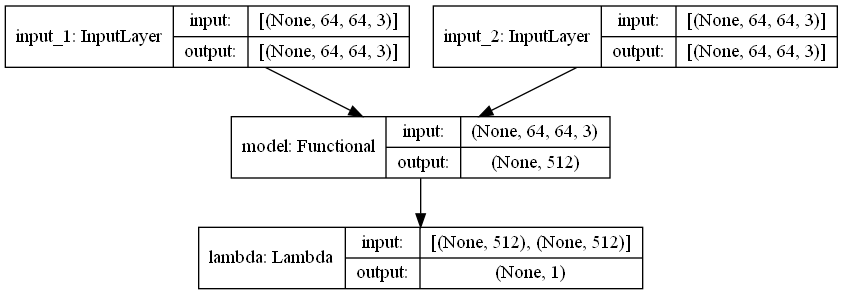

In [6]:
tf.keras.utils.plot_model(model, to_file='model.png',show_shapes=True)

In [15]:
callbacks_list=[ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=10,verbose=1),
                ModelCheckpoint(filepath='model_save.h5',monitor='val_loss',save_best_only=True)
                ]

model.compile(optimizer=Adam(lr=0.001),loss=contrastive_loss,metrics=[accuracy])
history = model.fit(
      doubleGenerator(x_train, digit_indices_train,train_classes,8),
    steps_per_epoch=20,
    validation_data=doubleGenerator(x_test, digit_indices_test,test_classes,8),
    validation_steps=4,
    batch_size=64,
    callbacks=callbacks_list,
      epochs=40)

Epoch 1/40
20/20 [==============================] - 9s 128ms/step - loss: 0.1673 - accuracy: 0.7620 - val_loss: 0.0809 - val_accuracy: 0.9688
Epoch 2/40
20/20 [==============================] - 1s 45ms/step - loss: 0.1653 - accuracy: 0.8037 - val_loss: 0.0756 - val_accuracy: 1.0000
Epoch 3/40
20/20 [==============================] - 1s 43ms/step - loss: 0.1130 - accuracy: 0.9006 - val_loss: 0.0795 - val_accuracy: 0.9844
Epoch 4/40
20/20 [==============================] - 1s 43ms/step - loss: 0.1142 - accuracy: 0.8942 - val_loss: 0.0730 - val_accuracy: 1.0000
Epoch 5/40
20/20 [==============================] - 1s 44ms/step - loss: 0.1150 - accuracy: 0.8756 - val_loss: 0.0989 - val_accuracy: 0.9844
Epoch 6/40
20/20 [==============================] - 1s 43ms/step - loss: 0.0978 - accuracy: 0.9298 - val_loss: 0.0825 - val_accuracy: 0.9844
Epoch 7/40
20/20 [==============================] - 1s 43ms/step - loss: 0.1025 - accuracy: 0.9028 - val_loss: 0.0962 - val_accuracy: 0.9531
Epoch 8/40
2

## 验证模型

在未知人脸的情况下，也取得了95%的成绩，可以再继续优化模型和匹配逻辑，目前进行到此

In [16]:
test_loss, test_acc = model.evaluate_generator(doubleGenerator(x_test, digit_indices_test,test_classes,16), steps=2)
print('test acc:', test_acc)

test acc: 0.96875


C:\Users\Harvest10\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


根据直方图发现，同人脸和不同人脸的分数拉开了差距，模型有效

In [17]:
count=0
NIRA=[]
NGRA=[]
for i in doubleGenerator(x_test, digit_indices_test,test_classes,16):
    for j in range(len(i[0][0])):
        img1=i[0][0][j].reshape(1,64,64,3)
        img2=i[0][1][j].reshape(1,64,64,3)
        result=model.predict([img1,img2])
        if i[1][j]==1:
            NGRA.append(result[0][0])
        else:
            NIRA.append(result[0][0])
    count+=1
    if count==2:
        break

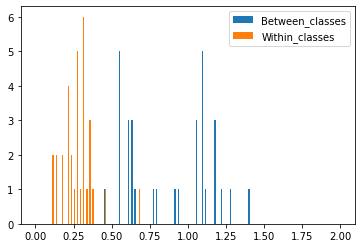

In [18]:
import matplotlib.pyplot as plt
import numpy


bins = numpy.linspace(0,2, 100)
plt.hist([NIRA,NGRA], bins,label=['Between_classes','Within_classes'])
plt.legend(loc='upper right')
plt.show()